# Nifty_50 Research

Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
#from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive

drive.mount('drive/', force_remount=True)

Mounted at drive/


In [ ]:
df=pd.read_excel("drive/My Drive/2025/NIFTY/work/index.xlsx")

In [ ]:
df.head(10)

,Date,Open,High,Low,Close
0,2015-01-02,8288.700195,8410.599609,8288.700195,8395.450195
1,2015-01-05,8407.950195,8445.599609,8363.900391,8378.400391
2,2015-01-06,8325.299805,8327.849609,8111.350098,8127.350098
3,2015-01-07,8118.649902,8151.200195,8065.450195,8102.100098
4,2015-01-08,8191.399902,8243.500000,8167.299805,8234.599609
5,2015-01-09,8285.450195,8303.299805,8190.799805,8284.500000
6,2015-01-12,8291.349609,8332.599609,8245.599609,8323.000000
7,2015-01-13,8346.150391,8356.650391,8267.900391,8299.400391
8,2015-01-14,8307.250000,8326.450195,8236.650391,8277.549805
9,2015-01-15,8424.500000,8527.099609,8380.549805,8494.150391


In [ ]:
df.isnull().sum()

,0
Date,0
Open,10
High,10
Low,10
Close,10


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2551 entries, 0 to 2550
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2551 non-null   datetime64[ns]
 1   Open    2541 non-null   float64       
 2   High    2541 non-null   float64       
 3   Low     2541 non-null   float64       
 4   Close   2541 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 99.8 KB


In [ ]:
df.describe()

,Date,Open,High,Low,Close
count,2551,2541.000000,2541.000000,2541.000000,2541.000000
mean,2020-03-03 02:36:55.601724928,13829.345496,13893.019183,13742.880744,13819.775921
min,2015-01-02 00:00:00,7023.649902,7034.200195,6825.799805,6970.600098
25%,2017-08-02 12:00:00,9522.950195,9599.849609,9473.450195,9525.750000
50%,2020-03-06 00:00:00,11646.849609,11694.849609,11571.349609,11641.799805
75%,2022-09-29 12:00:00,17768.500000,17827.750000,17652.550781,17757.000000
max,2025-04-30 00:00:00,26248.250000,26277.350000,26151.400000,26216.050000
std,NaN,5180.033944,5200.332666,5156.637308,5179.965920


In [ ]:
df.shape

(2551, 5)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0


In [ ]:
# If 'Date' is a column but has a time component, clean and convert it:
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'].astype(str).str.split(' ').str[0])

# If the date is under a different column name (like 'date' or 'timestamp'), update this accordingly:
elif 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'].astype(str).str.split(' ').str[0])

# If the date is in the index, reset it
elif df.index.name in ['Date', 'date', 'timestamp']:
    df = df.reset_index()
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]].astype(str).str.split(' ').str[0])
    df = df.rename(columns={df.columns[0]: 'Date'})

else:
    raise KeyError("No recognizable date column found. Please check df.columns.")


In [ ]:
#Date is set as an index

df.set_index('Date', inplace = True)

In [ ]:
df.head()

,Open,High,Low,Close
Date,,,,
2015-01-02,8288.700195,8410.599609,8288.700195,8395.450195
2015-01-05,8407.950195,8445.599609,8363.900391,8378.400391
2015-01-06,8325.299805,8327.849609,8111.350098,8127.350098
2015-01-07,8118.649902,8151.200195,8065.450195,8102.100098
2015-01-08,8191.399902,8243.500000,8167.299805,8234.599609


Rolling statistics
-----

smooth out short-term fluctuations, and make more reliable predictions.,Smoothing Noisy Data, Identifying Trends, Volatility Detection, Feature Engineering for Forecasting Models, Stationarity and Differencing

In [ ]:

window_size = 30  # Adjust this value as needed
df['Close_30'] = df['Close'].rolling(window=window_size).mean()

<Axes: xlabel='Date'>

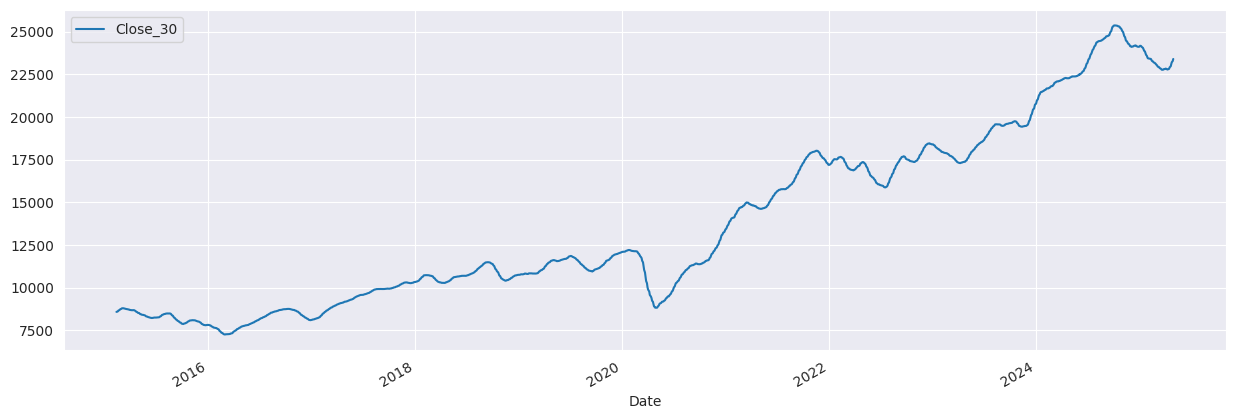

In [ ]:
df[['Close_30']].plot(figsize=(15,5))

In [ ]:
window_size = 50  # Adjust this value as needed
df['Close_50'] = df['Close'].rolling(window=window_size).mean()

<Axes: xlabel='Date'>

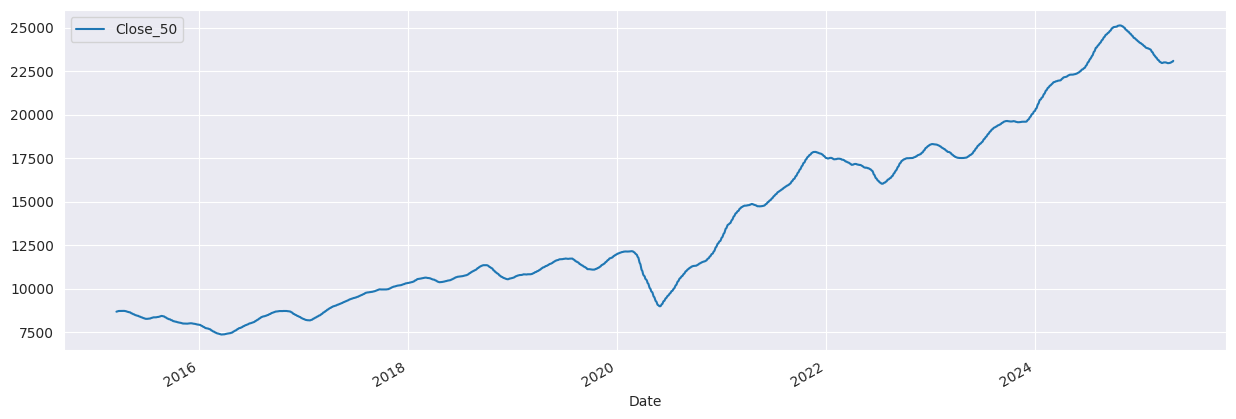

In [ ]:
df[['Close_50']].plot(figsize=(15,5))

In [ ]:
window_size = 200  # Adjust this value as needed
df['Close_200'] = df['Close'].rolling(window=window_size).mean()

<Axes: xlabel='Date'>

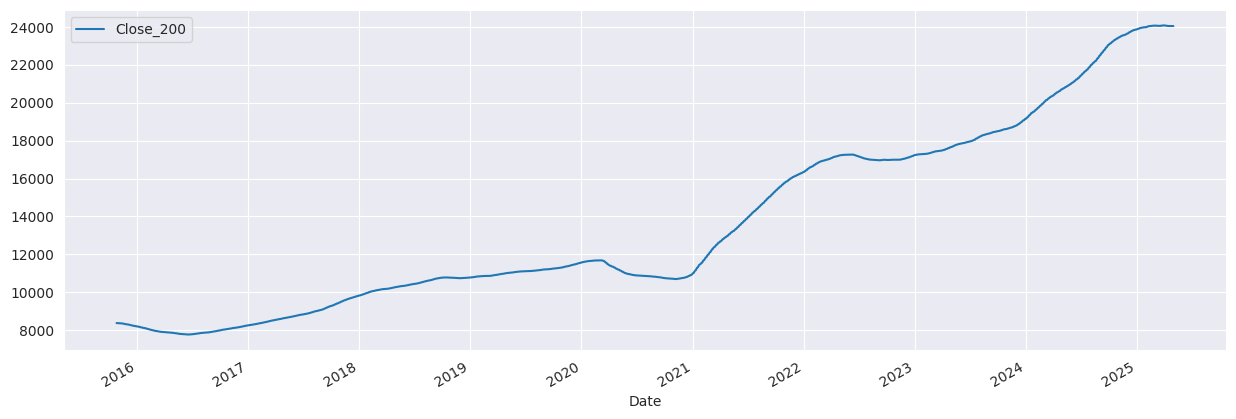

In [ ]:
df[['Close_200']].plot(figsize=(15,5))

In [ ]:
df.head()

,Open,High,Low,Close,Close_30,Close_50,Close_200
Date,,,,,,,
2015-01-02,8288.700195,8410.599609,8288.700195,8395.450195,NaN,NaN,NaN
2015-01-05,8407.950195,8445.599609,8363.900391,8378.400391,NaN,NaN,NaN
2015-01-06,8325.299805,8327.849609,8111.350098,8127.350098,NaN,NaN,NaN
2015-01-07,8118.649902,8151.200195,8065.450195,8102.100098,NaN,NaN,NaN
2015-01-08,8191.399902,8243.500000,8167.299805,8234.599609,NaN,NaN,NaN


Analyzing Daily Returns Based on Day-to-Day Price Changes
-----

In [ ]:
# Calculate daily returns
df['Daily_Return'] = df['Close'].pct_change()




Daily percentage return of the NIFTY 50 (or any asset) based on the closing prices, and stores it in a new column called 'Daily_Return'.

<Axes: xlabel='Date'>

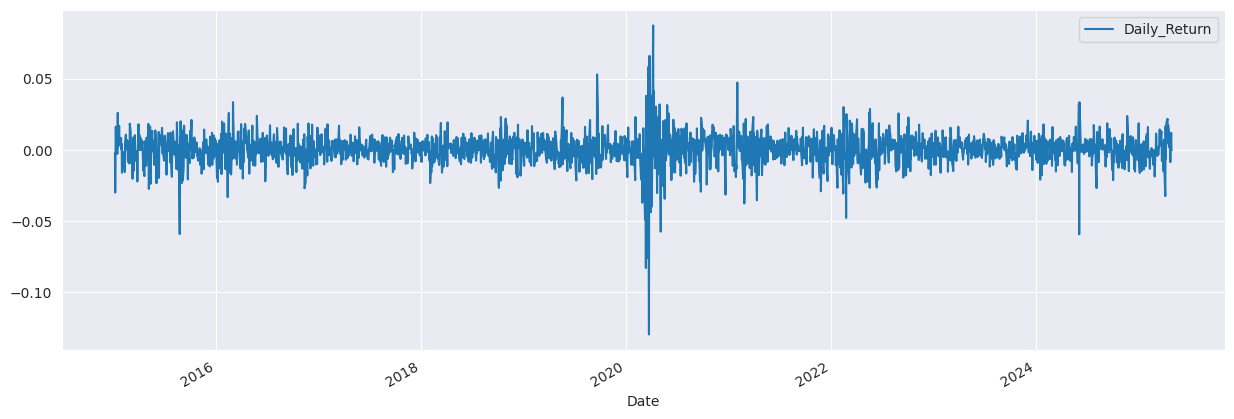

In [ ]:
df[['Daily_Return']].plot(figsize=(15,5))

The unusually high daily returns observed in the NIFTY 50 index during the initial months of 2020 can be primarily attributed to the onset of the COVID-19 pandemic and its profound impact on global and Indian financial markets. This period was marked by unprecedented volatility due to a confluence of factors, both domestic and international.

1. Market Overreactions: Initial panic led to sharp declines, followed by corrective rallies as investors reassessed the situation.

2. Government Stimulus: The Indian government announced economic stimulus packages to support the economy, which temporarily boosted investor confidence.

3. Global Market Movements: Global markets also experienced volatility, and positive movements abroad influenced the Indian markets.

4. Retail Investor Participation: The period saw a surge in retail investor activity, with over 10 million new demat accounts opened in 2020, contributing to increased trading volumes .

Data Stationarity
LSTM models assume that the underlying data patterns are relatively stable. The extreme fluctuations during the pandemic can violate this assumption, potentially leading to model inaccuracies, So prefer to validate model results in realtime market

In [ ]:
df.head()

,Open,High,Low,Close,Close_30,Close_50,Close_200,Daily_Return
Date,,,,,,,,
2015-01-02,8288.700195,8410.599609,8288.700195,8395.450195,NaN,NaN,NaN,NaN
2015-01-05,8407.950195,8445.599609,8363.900391,8378.400391,NaN,NaN,NaN,-0.002031
2015-01-06,8325.299805,8327.849609,8111.350098,8127.350098,NaN,NaN,NaN,-0.029964
2015-01-07,8118.649902,8151.200195,8065.450195,8102.100098,NaN,NaN,NaN,-0.003107
2015-01-08,8191.399902,8243.500000,8167.299805,8234.599609,NaN,NaN,NaN,0.016354


Volatility
--------

In [ ]:
# Calculate volatility (standard deviation of daily returns) over a specified window period
window = 20  # You can adjust the window period as needed
df['Volatility'] = df['Daily_Return'].rolling(window=window).std() * (252 ** 0.5)


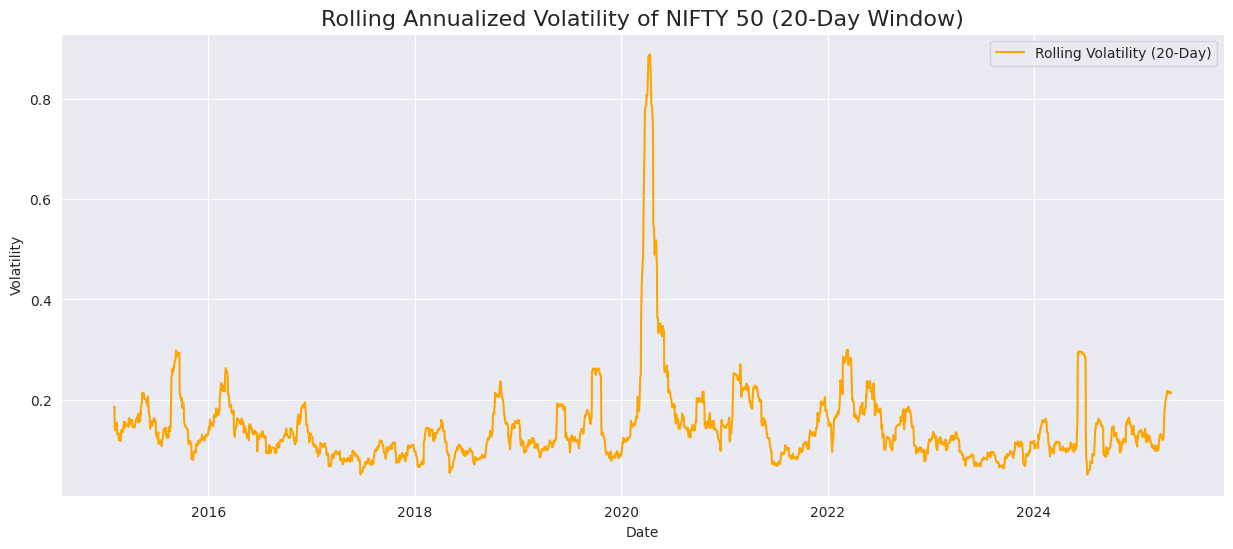

In [ ]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(15, 6))

# Plot volatility
plt.plot(df['Volatility'], label='Rolling Volatility (20-Day)', color='orange')

# Add title and labels
plt.title('Rolling Annualized Volatility of NIFTY 50 (20-Day Window)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

The high volatility in the initial months of 2020—especially February to April—was primarily caused by the COVID-19 pandemic, but several compounding factors intensified market instability during that time.

Impact on Forecasting Model:                                                                                                      
1.Non-Stationarity: This period may violate assumptions your LSTM depends on.

2. Outliers: Extreme return spikes can distort training patterns.

3. Overfitting Risk: The model might learn to expect abnormal volatility.

4. Recommendation: You might want to:                                                                                                                                                                                                                          a)Treat early 2020 as a special event period.

Use robust scaling, outlier handling, or b)exclude that period if modeling calm markets only.

Bollinger bands
---------

In [ ]:
# Define window period and number of standard deviations for Bollinger Bands
window = 20  # Window period for moving average
num_std_dev = 2  # Number of standard deviations

# Calculate rolling mean and standard deviation
df['Rolling_Mean'] = df['Close'].rolling(window=window).mean()
df['Rolling_Std'] = df['Close'].rolling(window=window).std()

# Calculate upper and lower Bollinger Bands
df['Upper_Band'] = df['Rolling_Mean'] + num_std_dev * df['Rolling_Std']
df['Lower_Band'] = df['Rolling_Mean'] - num_std_dev * df['Rolling_Std']

# Print the DataFrame to verify the changes
print(df)


                    Open          High           Low         Close  \
Date                                                                 
2015-01-02   8288.700195   8410.599609   8288.700195   8395.450195   
2015-01-05   8407.950195   8445.599609   8363.900391   8378.400391   
2015-01-06   8325.299805   8327.849609   8111.350098   8127.350098   
2015-01-07   8118.649902   8151.200195   8065.450195   8102.100098   
2015-01-08   8191.399902   8243.500000   8167.299805   8234.599609   
...                  ...           ...           ...           ...   
2025-04-24  24277.900000  24347.850000  24216.150000  24246.700000   
2025-04-25  24289.000000  24365.450000  23847.850000  24039.350000   
2025-04-28  24070.250000  24355.100000  24054.050000  24328.500000   
2025-04-29  24370.700000  24457.650000  24290.750000  24335.950000   
2025-04-30  24342.050000  24396.150000  24198.750000  24334.200000   

                Close_30   Close_50    Close_200  Daily_Return  Volatility  \
Date       

In [ ]:
# Define the period for Rate of Change calculation
roc_period = 20  # You can adjust the period as needed

# Calculate Rate of Change (ROC)
df['ROC'] = df['Close'].pct_change(periods=roc_period) * 100

# Print the DataFrame to verify the changes
print(df)


                    Open          High           Low         Close  \
Date                                                                 
2015-01-02   8288.700195   8410.599609   8288.700195   8395.450195   
2015-01-05   8407.950195   8445.599609   8363.900391   8378.400391   
2015-01-06   8325.299805   8327.849609   8111.350098   8127.350098   
2015-01-07   8118.649902   8151.200195   8065.450195   8102.100098   
2015-01-08   8191.399902   8243.500000   8167.299805   8234.599609   
...                  ...           ...           ...           ...   
2025-04-24  24277.900000  24347.850000  24216.150000  24246.700000   
2025-04-25  24289.000000  24365.450000  23847.850000  24039.350000   
2025-04-28  24070.250000  24355.100000  24054.050000  24328.500000   
2025-04-29  24370.700000  24457.650000  24290.750000  24335.950000   
2025-04-30  24342.050000  24396.150000  24198.750000  24334.200000   

                Close_30   Close_50    Close_200  Daily_Return  Volatility  \
Date       

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2541 entries, 2015-01-02 to 2025-04-30
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2541 non-null   float64
 1   High          2541 non-null   float64
 2   Low           2541 non-null   float64
 3   Close         2541 non-null   float64
 4   Close_30      2512 non-null   float64
 5   Close_50      2492 non-null   float64
 6   Close_200     2342 non-null   float64
 7   Daily_Return  2540 non-null   float64
 8   Volatility    2521 non-null   float64
 9   Rolling_Mean  2522 non-null   float64
 10  Rolling_Std   2522 non-null   float64
 11  Upper_Band    2522 non-null   float64
 12  Lower_Band    2522 non-null   float64
 13  ROC           2521 non-null   float64
dtypes: float64(14)
memory usage: 297.8 KB


In [ ]:
df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Close_30,29
Close_50,49
Close_200,199
Daily_Return,1
Volatility,20
Rolling_Mean,19


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Close_30,0
Close_50,0
Close_200,0
Daily_Return,0
Volatility,0
Rolling_Mean,0


In [ ]:
import pandas as pd
df1 = df.copy()

In [ ]:
# Assuming df is your preprocessed DataFrame

# Save the DataFrame to a CSV file
df.to_csv('preprocessed_data.csv', index=False)

In [ ]:
# Reset the index of DataFrame and save it as a new attribute
df2 = df1.reset_index()




In [ ]:
df2.head()

,Date,Open,High,Low,Close,Close_30,Close_50,Close_200,Daily_Return,Volatility,Rolling_Mean,Rolling_Std,Upper_Band,Lower_Band,ROC
0,2015-10-26,8333.650391,8336.299805,8252.049805,8260.549805,8031.155029,8038.038018,8374.332747,-0.004207,0.114191,8116.060034,152.556407,8421.172848,7810.947221,5.284250
1,2015-10-27,8230.349609,8241.950195,8217.049805,8232.900391,8044.965039,8035.707022,8373.519998,-0.003347,0.116114,8134.280054,142.887885,8420.055823,7848.504285,4.631129
2,2015-10-28,8188.899902,8209.099609,8131.799805,8171.200195,8057.735042,8032.014033,8372.483997,-0.007494,0.113944,8153.055054,118.676643,8390.408340,7915.701767,4.816758
3,2015-10-29,8175.450195,8179.600098,8098.000000,8111.750000,8068.483382,8023.878037,8372.405996,-0.007276,0.117968,8166.477563,94.521867,8355.521298,7977.433829,3.422669
4,2015-10-30,8123.549805,8146.100098,8044.399902,8065.799805,8074.935042,8015.648037,8372.224495,-0.005665,0.112085,8172.322559,83.308551,8338.939660,8005.705457,1.470643


In [ ]:
# Assuming df is your preprocessed DataFrame

# Save the DataFrame to a CSV file
df2.to_csv('preprocessedd_data.csv', index=False)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2342 entries, 2015-10-26 to 2025-04-30
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2342 non-null   float64
 1   High          2342 non-null   float64
 2   Low           2342 non-null   float64
 3   Close         2342 non-null   float64
 4   Close_30      2342 non-null   float64
 5   Close_50      2342 non-null   float64
 6   Close_200     2342 non-null   float64
 7   Daily_Return  2342 non-null   float64
 8   Volatility    2342 non-null   float64
 9   Rolling_Mean  2342 non-null   float64
 10  Rolling_Std   2342 non-null   float64
 11  Upper_Band    2342 non-null   float64
 12  Lower_Band    2342 non-null   float64
 13  ROC           2342 non-null   float64
dtypes: float64(14)
memory usage: 274.5 KB


Differncing
-----

1. To Achieve Stationarity
Most time series models (ARIMA, LSTM) work best with stationary data—where the mean and variance are constant over time.

Differencing removes trends and seasonality, helping the data become more stable and predictable.

2. Improves Forecast Accuracy
Helps the model focus on changes in the data rather than levels, improving pattern recognition.

Especially useful for financial data like stock prices, which are usually non-stationary.

3. Reduces Autocorrelation
Reduces the relationship between observations across time, which can improve the model's assumptions and residual analysis.

4. Helps Avoid Spurious Patterns
Raw time series might show trends that mislead models into learning false relationships. Differencing neutralizes this.

When to Use Differencing?
When the series shows a clear upward/downward trend

When Augmented Dickey-Fuller (ADF) test fails (i.e., indicates non-stationarity)

When autocorrelation plots show strong lags

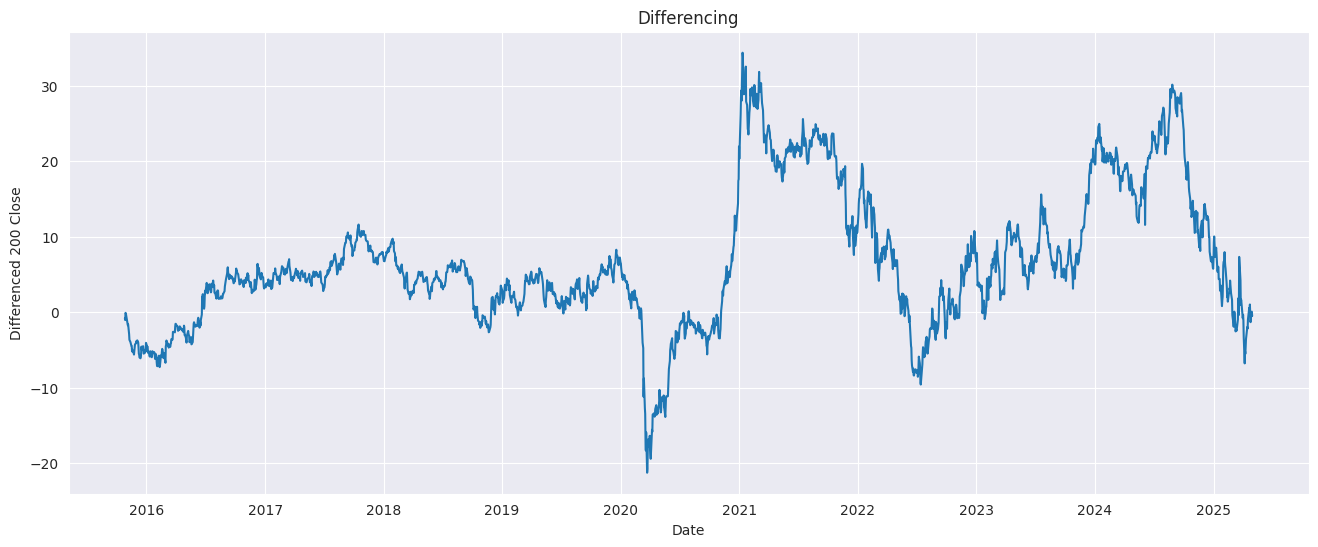

In [ ]:
import pandas as pd
# Assuming 'df' is your DataFrame with the 'rolling_Close 200' attribute
# Apply first differencing to make the time series more stationary
df1['Close_diff'] = df1['Close_200'].diff()

# Drop the first row since it will have NaN value after differencing
df.dropna(inplace=True)

# Visualize the differenced time series
plt.figure(figsize=(16, 6))
plt.plot(df1.index, df1['Close_diff'])
plt.xlabel('Date')
plt.ylabel('Differenced 200 Close')
plt.title('Differencing')
plt.grid(True)  # Add gridlines for better readability
plt.show()

<Axes: xlabel='Date'>

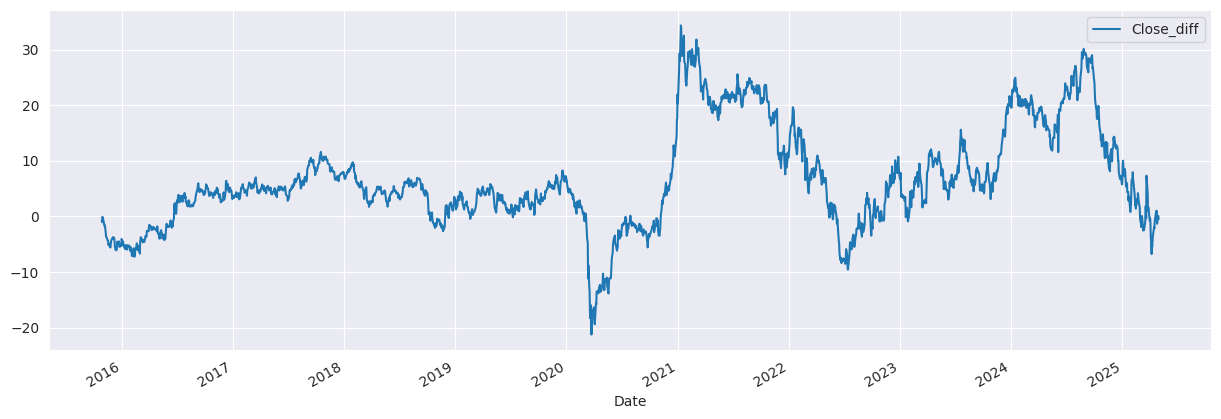

In [ ]:
df1[['Close_diff']].plot(figsize=(15,5))

In [ ]:
window_size = 200  # Adjust this value as needed
df1['Close_diff_200'] = df1['Close_diff'].rolling(window=window_size).mean()

<Axes: xlabel='Date'>

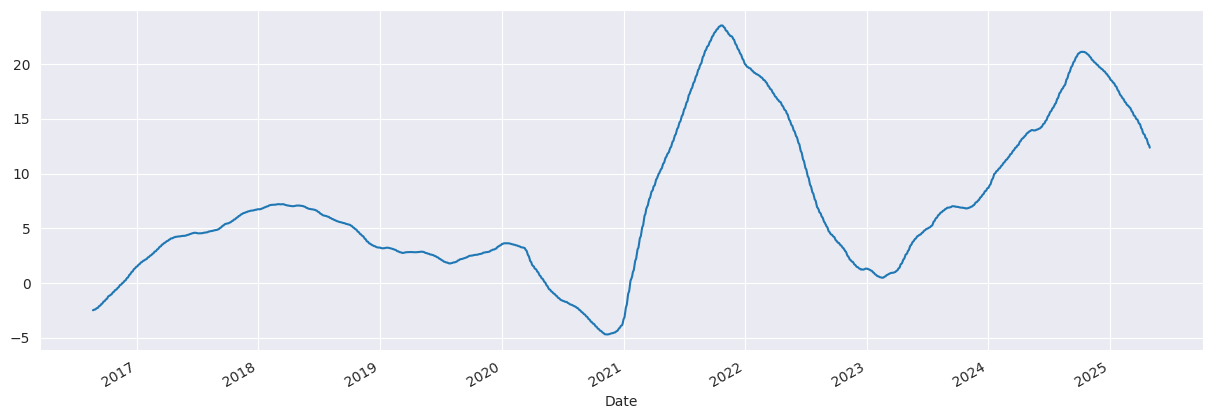

In [ ]:
df1['Close_diff_200'].plot(figsize=(15,5))

In [ ]:
# Assuming 'Close_diff_200' is the current name of the attribute you want to rename
df1.rename(columns={'Close_diff_200': 'Close_differnced'}, inplace=True)


In [ ]:
df1.head()

,Open,High,Low,Close,Close_30,Close_50,Close_200,Daily_Return,Volatility,Rolling_Mean,Rolling_Std,Upper_Band,Lower_Band,ROC,Close_diff,Close_differnced
Date,,,,,,,,,,,,,,,,
2015-10-26,8333.650391,8336.299805,8252.049805,8260.549805,8031.155029,8038.038018,8374.332747,-0.004207,0.114191,8116.060034,152.556407,8421.172848,7810.947221,5.284250,NaN,NaN
2015-10-27,8230.349609,8241.950195,8217.049805,8232.900391,8044.965039,8035.707022,8373.519998,-0.003347,0.116114,8134.280054,142.887885,8420.055823,7848.504285,4.631129,-0.812749,NaN
2015-10-28,8188.899902,8209.099609,8131.799805,8171.200195,8057.735042,8032.014033,8372.483997,-0.007494,0.113944,8153.055054,118.676643,8390.408340,7915.701767,4.816758,-1.036001,NaN
2015-10-29,8175.450195,8179.600098,8098.000000,8111.750000,8068.483382,8023.878037,8372.405996,-0.007276,0.117968,8166.477563,94.521867,8355.521298,7977.433829,3.422669,-0.078000,NaN
2015-10-30,8123.549805,8146.100098,8044.399902,8065.799805,8074.935042,8015.648037,8372.224495,-0.005665,0.112085,8172.322559,83.308551,8338.939660,8005.705457,1.470643,-0.181501,NaN


In [ ]:
df1.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Close_30,0
Close_50,0
Close_200,0
Daily_Return,0
Volatility,0
Rolling_Mean,0


Dickey-Fuller test
------------

In [ ]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print('ADF:', dftest[0])
    print('P-value:', dftest[1])
    print('No. of lags:', dftest[2])
    print('Observation:', dftest[3])
    print('Critical values:')
    df1['Close_diff'].plot(label='original')


    for key, val in dftest[4].items():
        print('\t', key, ':', val)

ADF: -2.675626033953372
P-value: 0.07835182823498106
No. of lags: 6
Observation: 2334
Critical values:
	 1% : -3.4331548442701627
	 5% : -2.8627791265652154
	 10% : -2.56742964160809


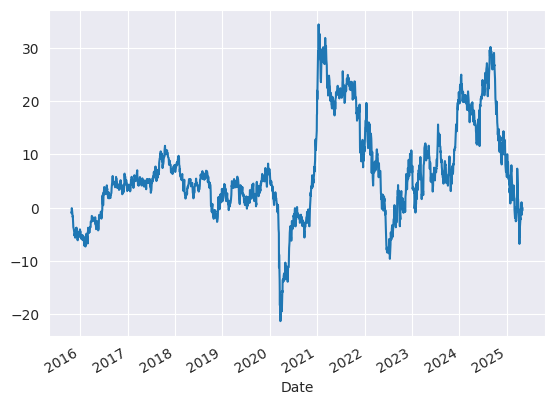

In [ ]:
# Replace inf values and drop NaN values
df1['Close_diff'] = df1['Close_diff'].replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values
df1_cleaned = df1.dropna(subset=['Close_diff'])

# Perform the ADF test on cleaned data
ad_test(df1_cleaned['Close_diff'])



In [ ]:
df1.head()

,Open,High,Low,Close,Close_30,Close_50,Close_200,Daily_Return,Volatility,Rolling_Mean,Rolling_Std,Upper_Band,Lower_Band,ROC,Close_diff,Close_differnced
Date,,,,,,,,,,,,,,,,
2015-10-26,8333.650391,8336.299805,8252.049805,8260.549805,8031.155029,8038.038018,8374.332747,-0.004207,0.114191,8116.060034,152.556407,8421.172848,7810.947221,5.284250,NaN,NaN
2015-10-27,8230.349609,8241.950195,8217.049805,8232.900391,8044.965039,8035.707022,8373.519998,-0.003347,0.116114,8134.280054,142.887885,8420.055823,7848.504285,4.631129,-0.812749,NaN
2015-10-28,8188.899902,8209.099609,8131.799805,8171.200195,8057.735042,8032.014033,8372.483997,-0.007494,0.113944,8153.055054,118.676643,8390.408340,7915.701767,4.816758,-1.036001,NaN
2015-10-29,8175.450195,8179.600098,8098.000000,8111.750000,8068.483382,8023.878037,8372.405996,-0.007276,0.117968,8166.477563,94.521867,8355.521298,7977.433829,3.422669,-0.078000,NaN
2015-10-30,8123.549805,8146.100098,8044.399902,8065.799805,8074.935042,8015.648037,8372.224495,-0.005665,0.112085,8172.322559,83.308551,8338.939660,8005.705457,1.470643,-0.181501,NaN


In [ ]:
df1.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Close_30,0
Close_50,0
Close_200,0
Daily_Return,0
Volatility,0
Rolling_Mean,0


In [ ]:
df1.dropna(inplace=True)

Normalization
------

In [ ]:
scaler = MinMaxScaler()
x = df1['Close_diff'].values.reshape(-1,1)
df1['Close_diff'] = scaler.fit_transform(x)


Model Building
--------

ARIMA
----

In [ ]:
#checking the best arima model, here p,d,q are default values.

'''model = auto_arima(df1['Close_diff'], trace = True, supress_warnings = False)
model.summary()'''

"model = auto_arima(df1['Close_diff'], trace = True, supress_warnings = False)\nmodel.summary()"

In [ ]:
data = df1['Close_diff']
length = int(len(df1['Close_diff']) * 0.85)
print('Length:', length)
print('Data length:',len(data))
train = data.iloc[:length]
print('training shape',train.shape)
test = data.iloc[length:]
print('testing shape',test.shape)

Length: 1820
Data length: 2142
training shape (1820,)
testing shape (322,)


In [ ]:
#Building the arima model with p,d,q = 3,2,2 values. These values can be adjusted accordingly.

model1 = ARIMA(train, order = (3,2,2))
model1 = model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1820
Model:                 ARIMA(3, 2, 2)   Log Likelihood                4856.481
Date:                Sun, 15 Jun 2025   AIC                          -9700.962
Time:                        18:40:34   BIC                          -9667.929
Sample:                             0   HQIC                         -9688.774
                               - 1820                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9521      0.823     -1.157      0.247      -2.566       0.661
ar.L2          0.0345      0.030      1.147      0.251      -0.024       0.093
ar.L3          0.0118      0.021      0.572      0.5

In [ ]:
#Splitting the data for arima model

start = len(train)
end = len(train) + len(test) - 1
pred1 = model1.predict(start = start, end = end, typ = 'levels')
pred1.index = data.index[start:end+1]

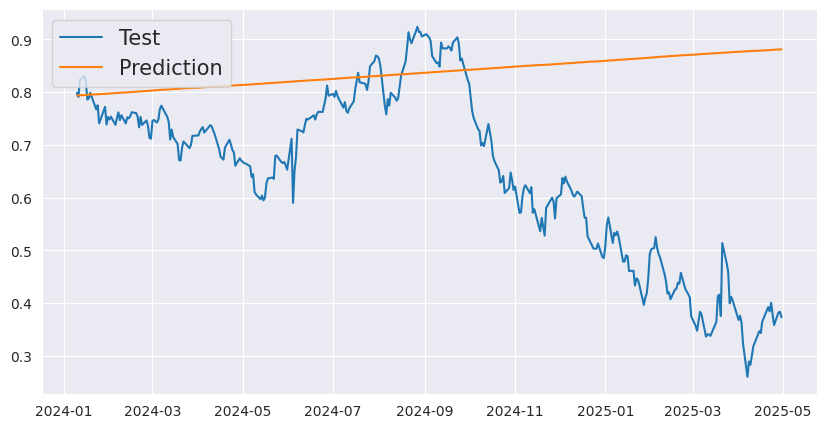

In [ ]:
plt.figure(figsize = (10, 5))

plt.plot(test)
plt.plot(pred1)
plt.legend(['Test','Prediction'], loc = 'upper left', fontsize = 15)

plt.show()

In [ ]:
print(np.sqrt(mean_squared_error(test, pred1)))

0.2611863866748257


In [ ]:
#checking the last date value, so that future dates' stocks can be predicted based on the model.

print(data.tail(10))

Date
2025-04-16    0.343293
2025-04-17    0.364753
2025-04-21    0.392419
2025-04-22    0.384361
2025-04-23    0.400522
2025-04-24    0.378509
2025-04-25    0.358465
2025-04-28    0.382505
2025-04-29    0.383471
2025-04-30    0.373188
Name: Close_diff, dtype: float64


In [ ]:
print('data length',df1.shape)

train = df1['Close_diff'].iloc[:length]
test = df1['Close_diff'].iloc[length - 60:]

print('Training length', len(train))
print('Teating length', len(test))

data length (2142, 16)
Training length 1820
Teating length 382


In [ ]:
x_train = []
y_train = []

for i in range(60, len(train)):
    x_train.append(train[i-60:i])
    y_train.append(train[i])

    if i <=61:
        print(x_train)
        print(y_train)

[Date
2016-08-22    0.415218
2016-08-23    0.418014
2016-08-24    0.425151
2016-08-25    0.425272
2016-08-26    0.427636
2016-08-29    0.432121
2016-08-30    0.443537
2016-08-31    0.449141
2016-09-01    0.455720
2016-09-02    0.458970
2016-09-06    0.474470
2016-09-07    0.484070
2016-09-08    0.489072
2016-09-09    0.477374
2016-09-12    0.461010
2016-09-14    0.471504
2016-09-15    0.462965
2016-09-16    0.465077
2016-09-19    0.468300
2016-09-20    0.466965
2016-09-21    0.462385
2016-09-22    0.465208
2016-09-23    0.462651
2016-09-26    0.451132
2016-09-27    0.451752
2016-09-28    0.461275
2016-09-29    0.454835
2016-09-30    0.458107
2016-10-03    0.475243
2016-10-04    0.486052
2016-10-05    0.477423
2016-10-06    0.480879
2016-10-07    0.476246
2016-10-10    0.472682
2016-10-13    0.456013
2016-10-14    0.448516
2016-10-17    0.450260
2016-10-18    0.457900
2016-10-19    0.460556
2016-10-20    0.457001
2016-10-21    0.456871
2016-10-24    0.452539
2016-10-25    0.450610
2016-

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)
print(y_train.shape)

(1760, 60, 1)
(1760,)


In [ ]:
x_test = []

for i in range(60, len(test)):
    x_test.append(test[i-60:i])

x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print(x_test.shape)

(322, 60, 1)


In [ ]:
y_test = df1['Close_diff'].iloc[length:]
y_test.shape
#y_test

(322,)

LSTM MODEL
----

In [ ]:
!pip install tensorflow

In [ ]:
!pip install numpy pandas matplotlib scikit-learn tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model3 = Sequential()

# LSTM layer with dropout to reduce overfitting
model3.add(LSTM(50, return_sequences=False, input_shape=(x_train.shape[1], 1)))
model3.add(Dropout(0.2))  # Optional but recommended

# Dense layers
model3.add(Dense(20, activation='relu'))
model3.add(Dense(1))  # Output layer

# Compile model
model3.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0863
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0024
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0017
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0014
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0014
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0012
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0011
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0010
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.8752e-04
Epoch 10/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 9.1009e-04
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Root Mean Squared Error: 0.05244069167829383


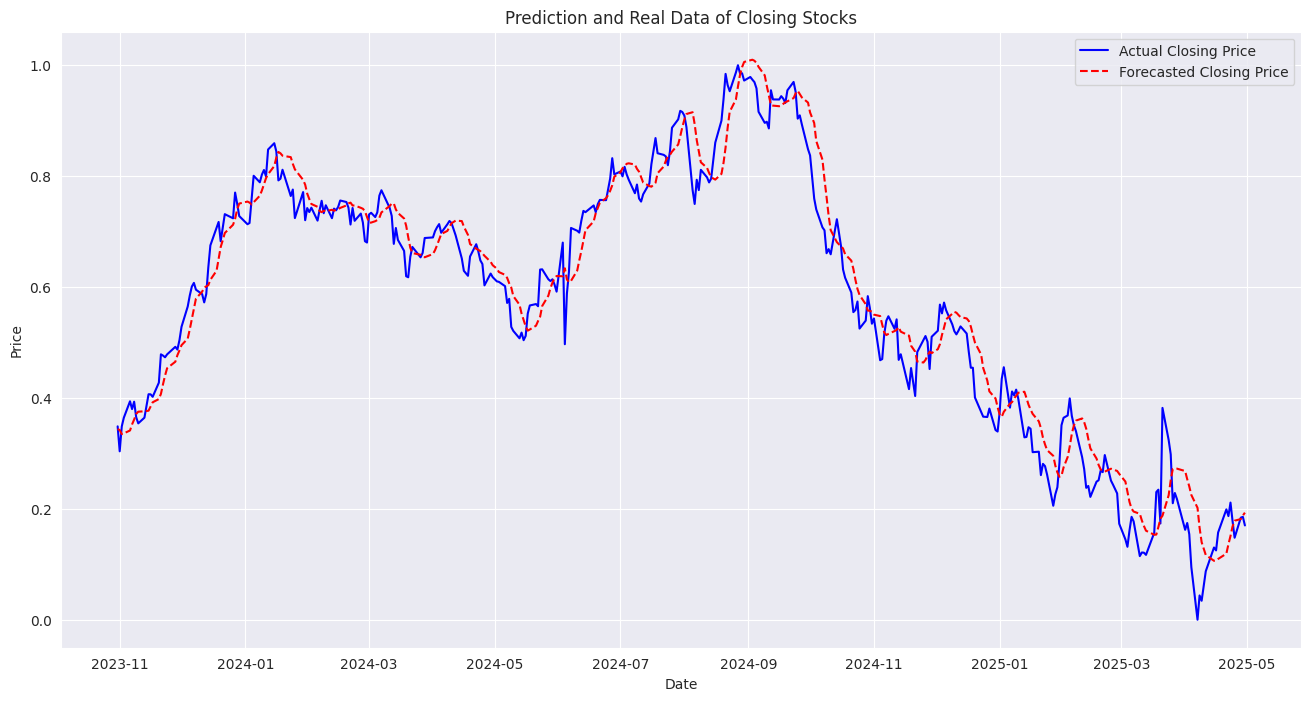

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

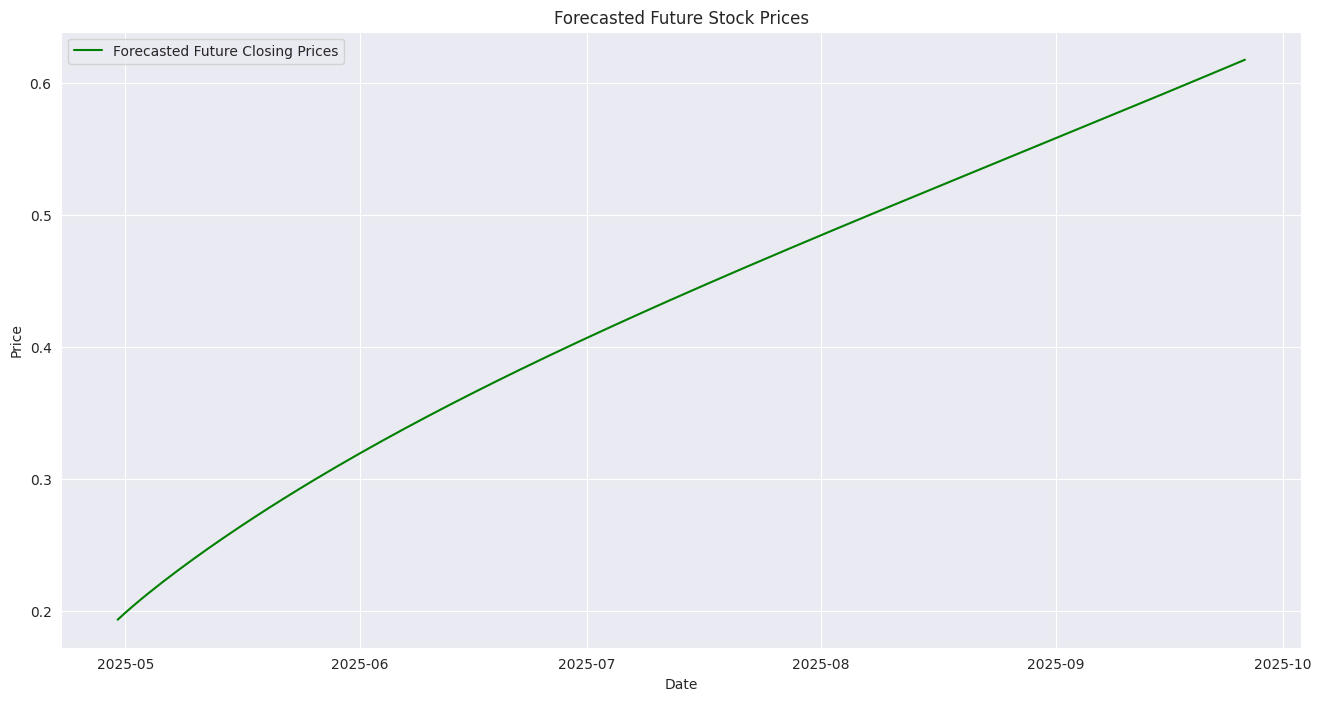

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import timedelta

# Function to preprocess data
def preprocess_data(df, timestep=60):
    # Scaling the 'Close_diff' column
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df['Close_diff'].values.reshape(-1, 1))

    X, y = [], []
    for i in range(timestep, len(scaled_data)):
        X.append(scaled_data[i-timestep:i, 0])
        y.append(scaled_data[i, 0])

    X = np.array(X)
    y = np.array(y)

    # Reshape X for LSTM input
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

# Function to create and compile the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape, return_sequences=False))
    model.add(Dense(20))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to insert new input at the end of the sequence
def insert_end(Xin, new_input, timestep=60):
    Xin[:, :-1, :] = Xin[:, 1:, :]
    Xin[:, -1, :] = new_input
    return Xin

# Load the data (replace 'df1' with your actual DataFrame)
# df1 = pd.read_csv('path_to_your_data.csv')  # Your DataFrame should be loaded here

# Preprocessing data
timestep = 60
X_train, y_train, scaler = preprocess_data(df1, timestep)
X_test, y_test, _ = preprocess_data(df1[int(0.8 * len(df1)):], timestep)

# Create and train the model
model3 = create_lstm_model(input_shape=(X_train.shape[1], 1))
model3.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions
pred = model3.predict(X_test)
pred = scaler.inverse_transform(pred)  # Inverse transform the predictions
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, pred))
print(f'Root Mean Squared Error: {rmse}')

# Plot actual vs predicted values
plt.figure(figsize=(16, 8))
plt.plot(df1.index[len(df1)-len(y_test):], y_test_actual, color='blue', label='Actual Closing Price')
plt.plot(df1.index[len(df1)-len(y_test):], pred, color='red', linestyle='dashed', label='Forecasted Closing Price')
plt.title('Prediction and Real Data of Closing Stocks')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Predict future values
future = 150
forecasted_values = []
Xin = X_test[-1:, :, :]
time = [pd.to_datetime(df1.index[-1]) + timedelta(days=i) for i in range(future)]

# Loop to predict future values
for i in range(future):
    out = model3.predict(Xin[:, :timestep, :], batch_size=5)  # Keep only the last 60 timesteps
    forecasted_values.append(out[0, 0])
    Xin = insert_end(Xin[:, :timestep, :], out[0, 0])  # Keep only the last 60 timesteps

# Inverse transform and create a DataFrame for the forecasted values
forecasted_output = np.array(forecasted_values).reshape(-1, 1)
forecasted_output = scaler.inverse_transform(forecasted_output)
forecasted_output = pd.DataFrame(forecasted_output, columns=['Forecasted'])

# Create a DataFrame for the corresponding dates
date = pd.DataFrame(time, columns=['Date'])

# Combine the date and forecasted values into a single DataFrame
df_result = pd.concat([date, forecasted_output], axis=1)

# Plot the forecasted future values
plt.figure(figsize=(16, 8))
plt.plot(df_result['Date'], df_result['Forecasted'], color='green', label='Forecasted Future Closing Prices')
plt.title('Forecasted Future Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


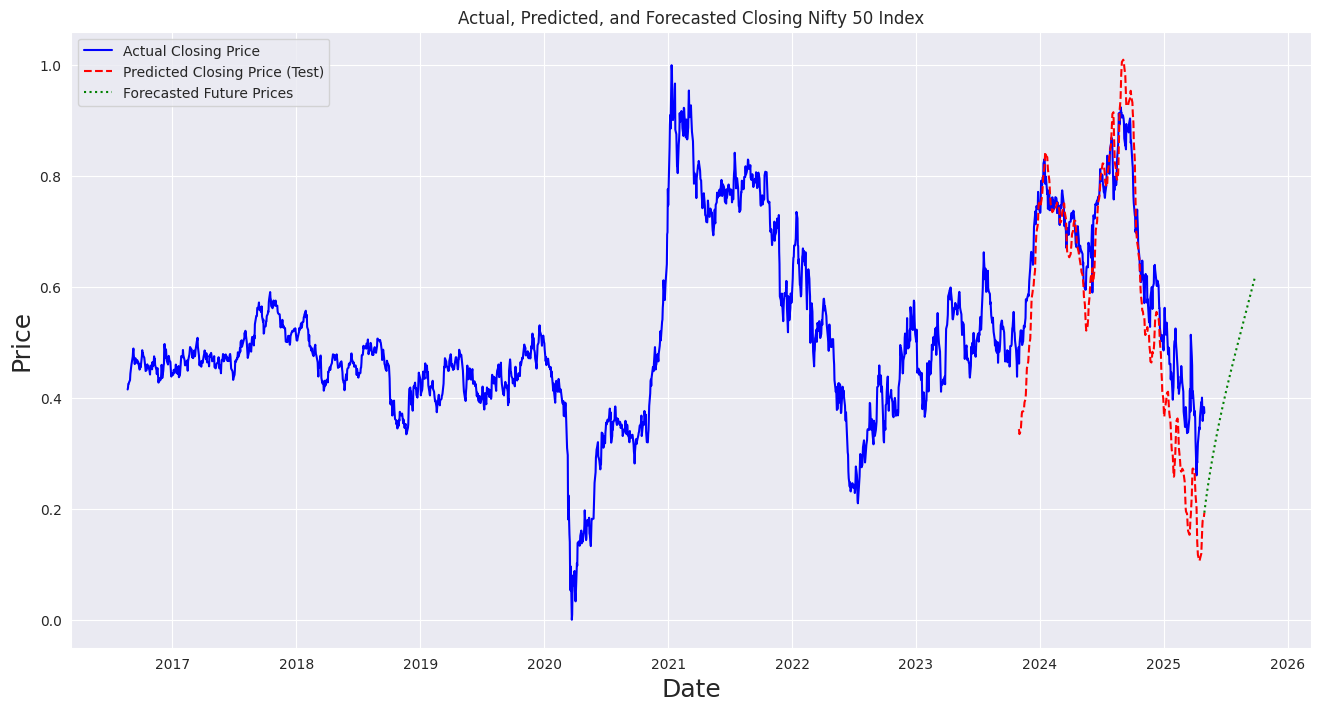

In [ ]:
import matplotlib.pyplot as plt

# Combine actual and forecasted values
plt.figure(figsize=(16, 8))

# Plot actual closing prices
plt.plot(df1['Close_diff'], label='Actual Closing Price', color='blue')

# Plot predicted closing prices on the test set
plt.plot(df1.index[len(df1)-len(y_test):], pred, label='Predicted Closing Price (Test)', color='red', linestyle='dashed')

# Plot forecasted future values
plt.plot(df_result['Date'], df_result['Forecasted'], label='Forecasted Future Prices', color='green', linestyle='dotted')

# Labels and title
plt.title('Actual, Predicted, and Forecasted Closing Nifty 50 Index')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)

# Adding legend
plt.legend()

# Display the plot
plt.show()


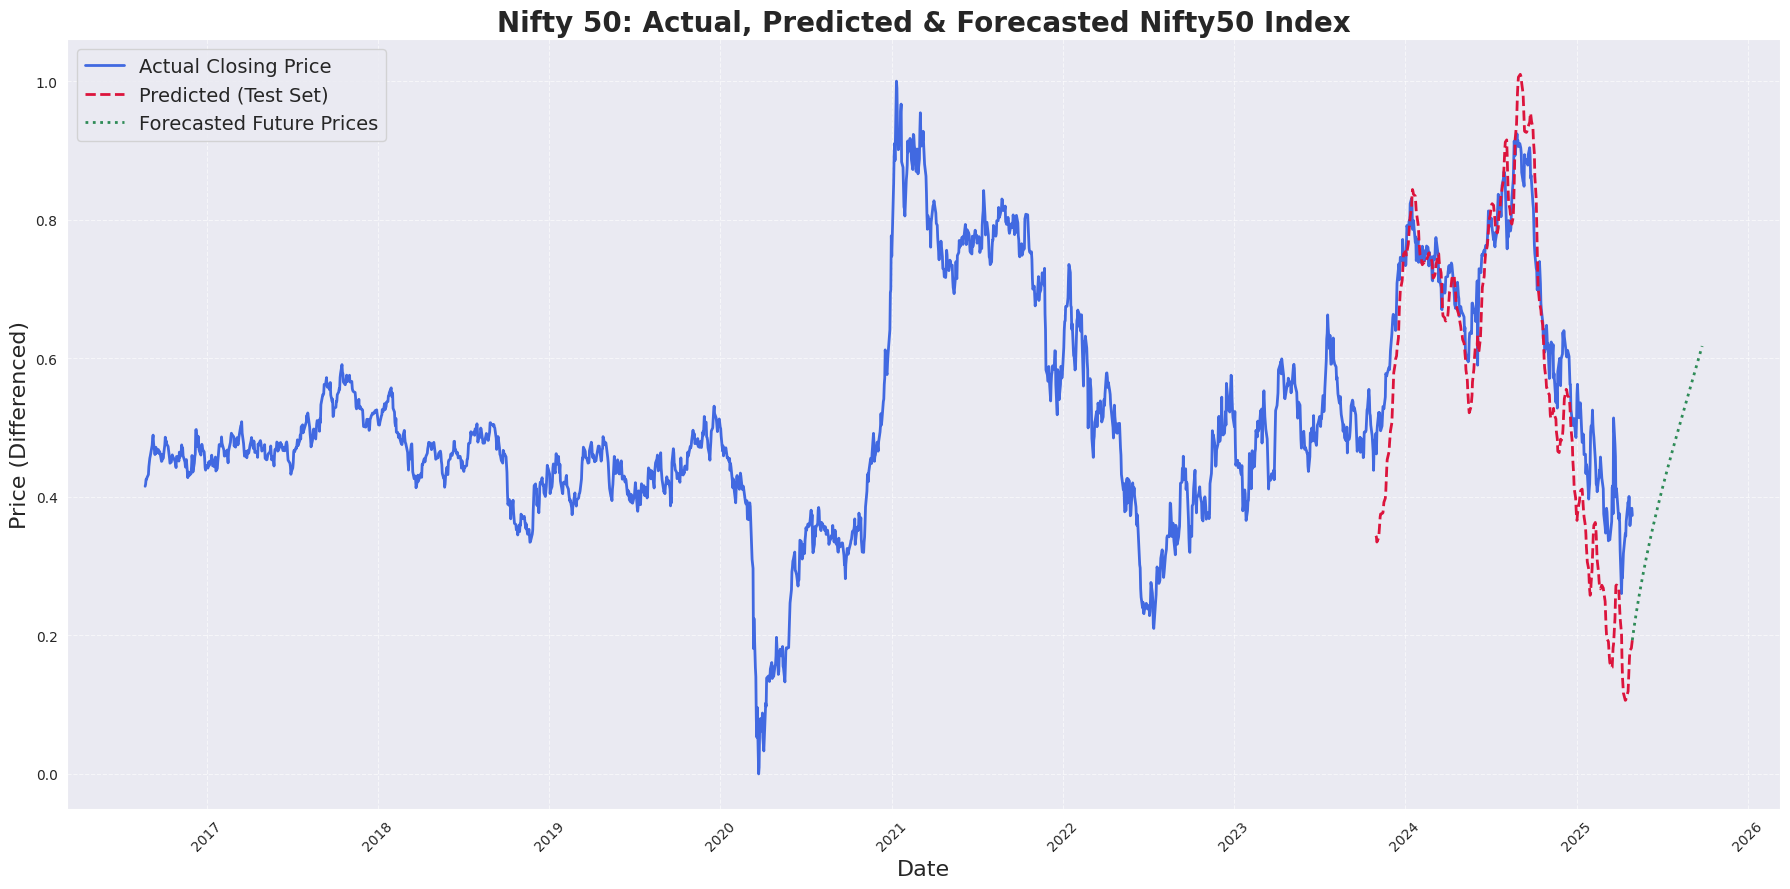

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#plt.style.use('seaborn-darkgrid')  # Optional: use a clean background style

# Create the plot
plt.figure(figsize=(18, 9))

# Plot actual closing prices
plt.plot(df1.index, df1['Close_diff'], label='Actual Closing Price', color='royalblue', linewidth=2)

# Plot predicted test set values
plt.plot(df1.index[len(df1)-len(y_test):], pred, label='Predicted (Test Set)', color='crimson', linestyle='--', linewidth=2)

# Plot future forecasted prices
plt.plot(df_result['Date'], df_result['Forecasted'], label='Forecasted Future Prices', color='seagreen', linestyle=':', linewidth=2)

# Enhancing date axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Title and labels
plt.title('Nifty 50: Actual, Predicted & Forecasted Nifty50 Index', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price (Differenced)', fontsize=16)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()
